In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# 0. Install Dependencies and Dataset

## 0.1 Install Python packages

In [1]:
%%bash
rm -rf sample_data

pip -q install tqdm
pip -q install kaggle
pip -q install tokenizers
pip -q install gensim

## 0.2 Download the dataset using the Kaggle API

In [2]:
%%bash
mkdir ~/.kaggle/
cd ~/.kaggle/
touch kaggle.json
chmod 600 /root/.kaggle/kaggle.json
echo "{\"username\":\"cwcrystal8\",\"key\":\"75ba9516cfea9c5de8e657080f7428bd\"}" > kaggle.json

cd /content/

kaggle datasets download -d mateibejan/multilingual-lyrics-for-genre-classification
unzip multilingual-lyrics-for-genre-classification.zip
rm test.csv
rm multilingual-lyrics-for-genre-classification.zip
mv train.csv data.csv


Archive:  multilingual-lyrics-for-genre-classification.zip
  inflating: test.csv                
  inflating: train.csv               


100%|##########| 103M/103M [00:00<00:00, 124MB/s] 


## 0.3 Clone the Github repo

In [3]:
%%bash
cd /content/
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf 6.864-lyric-analysis
git clone "https://github.com/sohinik/6.864-lyric-analysis.git"

Cloning into '6.864-lyric-analysis'...


In [ ]:
# %%bash
# wget http://nlp.stanford.edu/data/glove.6B.zip
# unzip glove*.zip

In [ ]:
# embeddings_index = {}

# f = open('glove.6B.100d.txt', encoding='utf-8')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

In [ ]:
import gensim

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

# Load Google's pre-trained Word2Vec model.
word2vec = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# 1. Clean and Format the Data

In [4]:
import numpy as np
import os
import random
import torch
from torch import cuda

os.chdir("/content/6.864-lyric-analysis")
print("Current Working Directory:", os.getcwd())

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(seed)
else:
  print('WARNING: you are running this assignment on a cpu!')
  device = 'cpu'

Current Working Directory: /content/6.864-lyric-analysis


In [ ]:
import utils
from data_processing import get_data
from utils import save_model, load_model

## Data Hyperparameters
clean_genre=True
genres=["Metal", "Jazz", "Hip-Hop", "Pop", "Folk", "Country"]

num_included=None
num_words_per_stanza = 150
training_ratio = 0.8

raw_data, train_dict, test_dict = get_data("../data.csv", 
                                 clean_genre = clean_genre,
                                 genres = genres,
                                 num_included = num_included,
                                 num_words_per_stanza = num_words_per_stanza,
                                 training_ratio = training_ratio)

In [ ]:
def get_descriptive_stats(data):
  lyrics = data["lyrics"]
  labels = data["labels"]

  freq_count = { x: labels.count(x) for x in set(labels)}

  print("Number of datapoints:", len(labels))
  print("Frequency counts:", freq_count)

print("Training data stats")
get_descriptive_stats(train_dict)
print()
print("Testing data stats")
get_descriptive_stats(test_dict)

Training data stats
Number of datapoints: 15750
Frequency counts: {'Country': 2625, 'Hip-Hop': 2625, 'Pop': 2625, 'Jazz': 2625, 'Metal': 2625, 'Folk': 2625}

Testing data stats
Number of datapoints: 3900
Frequency counts: {'Country': 650, 'Hip-Hop': 650, 'Pop': 650, 'Jazz': 650, 'Metal': 650, 'Folk': 650}


## 1.1 Tokenize the lyrics

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
tokenizer.train_from_iterator(train_dict["lyrics"] + test_dict["lyrics"])
tokenizer.enable_padding()

print([encoding.ids for encoding in tokenizer.encode_batch(train_dict['lyrics'][:5])])

[[871, 295, 1182, 268, 193, 12, 207, 364, 363, 4489, 5143, 12, 315, 7, 196, 1271, 400, 220, 188, 717, 231, 7, 83, 727, 14, 3270, 1161, 12, 364, 363, 3044, 3211, 738, 12, 41, 7, 195, 12452, 1480, 12, 278, 192, 259, 7, 84, 498, 268, 193, 1, 471, 259, 192, 318, 201, 1416, 31, 981, 450, 12, 41, 7, 77, 710, 365, 356, 12, 399, 12, 330, 450, 12, 41, 7, 77, 710, 365, 356, 1, 253, 281, 188, 1538, 236, 1, 981, 450, 12, 41, 7, 77, 710, 365, 186, 305, 399, 12, 330, 15716, 220, 218, 188, 18429, 655, 12, 399, 1, 367, 301, 7, 83, 651, 198, 345, 351, 224, 262, 224, 7, 196, 282, 295, 438, 1, 1498, 651, 198, 345, 231, 5017, 7, 84, 424, 521, 12, 315, 262, 224, 7, 196, 282, 295, 438, 1, 1203, 201, 198, 215, 662, 1, 41, 7, 77, 1227, 207, 201, 1404, 7, 84, 1129, 12, 750, 920, 186, 188, 27184, 254, 22734, 218, 215, 2019, 12, 465, 7, 84, 583, 398, 435, 12, 286, 7, 84, 583, 398, 435, 12, 203, 242, 3584, 341, 10594, 253, 1, 1153, 479, 12, 345, 201, 450, 1, 192, 364, 242, 3584, 10594, 192, 1, 895, 1, 1024, 1, 10

## 1.2 Map genres to IDs

In [ ]:
all_labels = list(set(train_dict["labels"]) | set(test_dict["labels"]))
num_labels = len(all_labels)
all_labels.sort()
label_to_id_dict = {label: i for i, label in enumerate(all_labels)}
id_to_label_dict = {i: label for i, label in enumerate(all_labels)}

train_labels = list(map(lambda x: label_to_id_dict[x], train_dict["labels"]))
test_labels = list(map(lambda x: label_to_id_dict[x], test_dict["labels"]))

# 2. Design the Baseline Model


In [ ]:
import torch.nn as nn

class ModelOutputs:
    def __init__(self, logits = None, loss=None):
        self.logits = logits
        self.loss = loss

class GenreClassificationModel(nn.Module):
  def __init__(self, num_labels, embed_size = 300, 
               dropout=0.2, num_layers = 1, is_bidirectional = False):
    super(GenreClassificationModel, self).__init__()
    self.encoder = nn.GRU(
        input_size  = embed_size,
        hidden_size = num_labels,
        num_layers = num_layers,
        batch_first = True,
        bidirectional = is_bidirectional,
        dropout = dropout
        )
    self.bidirectional = is_bidirectional
    self.num_layers = num_layers
    

  def forward(self, input_ids, attn_mask=None, labels = None):
    '''
    Inputs;
    input_ids: (batch_size, num_tokens) tensor of input_ids
    attn_mask: (batch_size, num_tokens) tensor 
    labels (optional): (batch_size,) tensor


    Outputs:
    label_logits: (batch_size, num_labels) tensor of logits
    '''
    outputs, hidden_states = self.encoder(input_ids)

    if not self.bidirectional:
      logits = hidden_states[-1]
    else: 
      logits = torch.sum(hidden_states[-self.num_layers:], dim=0)

    loss = None

    if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
    
    return ModelOutputs(
        logits = logits,
        loss = loss)

  

# 3. Train the Model

## 3.1 Create the model

In [ ]:
model = GenreClassificationModel(num_labels, num_layers=2, is_bidirectional=True)
model = model.to(device)

In [ ]:
def vectorize_batch(batch_inputs, batch_labels, embed_size = 300):
  embedded_batch_inputs = []

  for lyric in batch_inputs:
    words = lyric.split()
    words = [word.strip(''',./!?\\{}()[]|-_=+@#$%^&*~`"<>;':''') for word in words]
    words = [word for word in words if word in word2vec.vocab]
    embeddings = [word2vec.word_vec(word) for word in words]
    if len(embeddings) > 0:
      embedded_batch_inputs.append(embeddings)

  max_len = max([len(words) for words in embedded_batch_inputs])

  batch_ids = torch.zeros((len(batch_inputs), max_len, embed_size), device=device)

  for i, embedding in enumerate(embedded_batch_inputs):
    batch_ids[i, :len(embedding), :] = torch.Tensor(embedding)

  batch_labels = torch.LongTensor(batch_labels).to(device)

  return batch_ids, batch_labels


## 3.4 Set the hyperparameters

In [ ]:
# Hyper-parameters: you could try playing with different settings
num_epochs = 3
learning_rate = 3e-5
weight_decay = 1e-5
eps = 1e-6
batch_size = 16
warmup_rate = 0.05

# Calculating the number of warmup steps
num_training_cases = len(train_labels)
t_total = (num_training_cases // batch_size + 1) * num_epochs
ext_warmup_steps = int(warmup_rate * t_total)

# Initializing an AdamW optimizer
ext_optim = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                              eps=eps, weight_decay=weight_decay)

print("***** Training Info *****")
print("  Num examples = %d" % t_total)
print("  Num Epochs = %d" % num_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % t_total)

***** Training Info *****
  Num examples = 2955
  Num Epochs = 3
  Batch size = 16
  Total optimization steps = 2955


## 3.5 Train

In [ ]:
model.train()
max_grad_norm = 1

step_id = 0
for _ in range(num_epochs):

    training_data = list(zip(train_dict["lyrics"], train_labels))
    random.shuffle(training_data)
    train_inputs, train_labels = list(zip(*training_data))

    train_inputs = list(train_inputs)
    train_labels = list(train_labels)

    for i in range(0, num_training_cases, batch_size):
        batch_inputs = train_inputs[i: i+batch_size]
        batch_labels = train_labels[i: i+batch_size]

        batch_ids, batch_labels = vectorize_batch(batch_inputs, batch_labels)

        model.zero_grad()
        outputs = model(            
            batch_ids,
            labels = batch_labels
        )
        
        # Back-propagate the loss signal and clip the gradients
        loss = outputs.loss.mean()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update neural network parameters and the learning rate
        ext_optim.step()

        if step_id % 20 == 0:
            print(f'At step {step_id}, the extraction loss = {loss}')
        
        step_id += 1

print('Finished Training')



At step 0, the extraction loss = 1.7856144905090332
At step 20, the extraction loss = 1.8526674509048462
At step 40, the extraction loss = 1.8672230243682861
At step 60, the extraction loss = 1.823568344116211
At step 80, the extraction loss = 1.751015543937683
At step 100, the extraction loss = 1.8628075122833252
At step 120, the extraction loss = 1.9367561340332031
At step 140, the extraction loss = 1.811505913734436
At step 160, the extraction loss = 1.7808763980865479
At step 180, the extraction loss = 1.7984352111816406
At step 200, the extraction loss = 1.7988733053207397
At step 220, the extraction loss = 1.786047339439392
At step 240, the extraction loss = 1.8362871408462524
At step 260, the extraction loss = 1.8075973987579346
At step 280, the extraction loss = 1.7533748149871826
At step 300, the extraction loss = 1.798216462135315
At step 320, the extraction loss = 1.8216160535812378
At step 340, the extraction loss = 1.8059005737304688
At step 360, the extraction loss = 1.75

# 4. Evaluate the Model


## 4.1 Calculate the basic cross entropy loss

In [ ]:
model.eval()

num_test_data = len(test_labels)
test_batch_size = 16

testing_data = list(zip(test_dict["lyrics"], test_labels))
random.shuffle(testing_data)
test_inputs, test_labels = list(zip(*testing_data))

test_inputs = list(test_inputs)
test_labels = list(test_labels)

total_loss = 0

confusion_matrix = torch.zeros((num_labels, num_labels)).to(device)
num_test_batches = 0

for i in range(0, num_test_data, test_batch_size):
    batch_inputs = test_inputs[i: i + test_batch_size]
    batch_labels = test_labels[i: i + test_batch_size]

    batch_ids, batch_labels = vectorize_batch(batch_inputs, batch_labels)

    with torch.no_grad():
      outputs = model(            
          batch_ids,
          labels=batch_labels
      )
    
    # Back-propagate the loss signal and clip the gradients
    total_loss += outputs.loss.mean()

    # Update confusion matrix
    logits = outputs.logits
    predictions = torch.argmax(logits, dim = 1)
    for label, pred in zip(batch_labels, predictions):
      confusion_matrix[label, pred] += 1

    num_test_batches += 1

avg_test_loss = total_loss / num_test_batches
print(f'The test loss is {avg_test_loss}')



The test loss is 1.8010447025299072


## 4.2 Calculate the accuracy, precision, and recall

Accuracy: 0.15641026198863983


,Precision,Recall
Country,0.115385,0.041538
Folk,0.146259,0.198462
Hip-Hop,0.179666,0.198462
Jazz,0.163324,0.263077
Metal,0.170686,0.141538
Pop,0.129167,0.095385


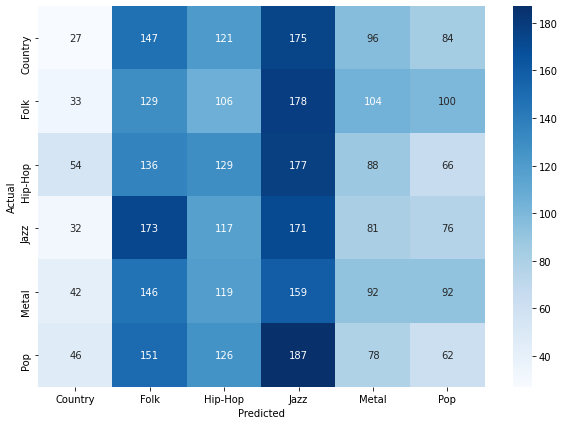

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


def get_recall(confusion_matrix):
  return torch.diag(confusion_matrix) / confusion_matrix.sum(dim = 1)

def get_precision(confusion_matrix):
  return torch.diag(confusion_matrix) / confusion_matrix.sum(dim = 0)

def get_accuracy(confusion_matrix):
  return torch.diag(confusion_matrix).sum() / confusion_matrix.sum()

def plot_confusion_matrix(confusion_matrix):
  df_cm = pd.DataFrame(confusion_matrix.cpu().numpy(), 
                     index = all_labels,
                     columns = all_labels)

  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')  
  plt.ylabel("Actual")
  plt.xlabel("Predicted")

def plot_statistics(confusion_matrix):
  accuracy = get_accuracy(confusion_matrix)
  print("Accuracy:", accuracy.item())

  recall = get_recall(confusion_matrix)
  precision = get_precision(confusion_matrix)

  return pd.DataFrame({"Precision": precision.cpu().numpy(), "Recall": recall.cpu().numpy()}, index = all_labels)

plot_confusion_matrix(confusion_matrix)
plot_statistics(confusion_matrix)

In [ ]:
plot_statistics(confusion_matrix)

Accuracy: 0.3472609221935272


,Precision,Recall
Hip-Hop,0.504348,0.064624
Jazz,0.340252,0.977159
Metal,NaN,0.000000


Implementation Notes:
1. Split songs up into stanzas with 150 words each
2. Truncated it at 512 tokens (due to BERT limits)
3. Used GRU to combine information from each word in the song, LSTM does not improve performance
4. Spread across 5 genres as default
5. Equal number of datapoints for each genre

Ideas:
1. Look into distribution within training/testing sample (maybe skewed??, not that many Metal/Rock examples?) --> Fixed, uniform distribution now
2. Add more layers/hidden size, train our own BERT with a larger token size
3. Get around truncation by splitting up songs by stanza/line --> implemented
4. Limit it to only genres with a lot of datapoints

In [ ]:
utils.save_model(model, "/content/three_layers_bidirectional.pt")

In [ ]:
loss = [1.7856144905090332,
1.8526674509048462,
1.8672230243682861,
1.823568344116211,
1.751015543937683,
1.8628075122833252,
1.9367561340332031,
1.811505913734436,
1.7808763980865479,
1.7984352111816406,
1.7988733053207397,
1.786047339439392,
1.8362871408462524,
1.8075973987579346,
1.7533748149871826,
1.798216462135315,
1.8216160535812378,
1.8059005737304688,
1.7593309879302979,
1.816662311553955,
1.8995198011398315,
1.8220551013946533,
1.8137987852096558,
1.7960201501846313,
1.829653263092041,
1.8320848941802979,
1.7103826999664307,
1.806888461112976,
1.7684619426727295,
1.8176206350326538,
1.8264433145523071,
1.7927753925323486,
1.9091975688934326,
1.8224780559539795,
1.8608709573745728,
1.8110041618347168,
1.8196393251419067,
1.7842897176742554,
1.8052150011062622,
1.728511929512024,
1.8265361785888672,
1.8218079805374146,
1.7515603303909302,
1.839066743850708,
1.8389513492584229,
1.7684611082077026,
1.741479754447937,
1.88340163230896,
1.8368772268295288,
1.8136945962905884,
1.7850559949874878,
1.8180574178695679,
1.8117488622665405,
1.853045105934143,
1.7679744958877563,
1.783363938331604,
1.7887805700302124,
1.7765421867370605,
1.8427397012710571,
1.7681668996810913,
1.8131898641586304,
1.813769817352295,
1.811204195022583,
1.8112119436264038,
1.8156286478042603,
1.8112035989761353,
1.7942132949829102,
1.8229751586914062,
1.8233531713485718,
1.8010907173156738,
1.7715251445770264,
1.857610821723938,
1.8223998546600342,
1.8774323463439941,
1.7540481090545654,
1.873958706855774,
1.781713843345642,
1.7763559818267822,
1.8097039461135864,
1.8779723644256592,
1.8165265321731567,
1.8108266592025757,
1.7006473541259766,
1.7903594970703125,
1.8051273822784424,
1.7849011421203613,
1.8720406293869019,
1.82823646068573,
1.8181055784225464,
1.7742940187454224,
1.8851628303527832,
1.827398419380188,
1.7978644371032715,
1.7457412481307983,
1.8019726276397705,
1.8282678127288818,
1.7811558246612549,
1.808627724647522,
1.8070714473724365,
1.8430638313293457,
1.8573565483093262,
1.8523167371749878,
1.8310637474060059,
1.7636384963989258,
1.7710483074188232,
1.7607170343399048,
1.777076244354248,
1.805694818496704,
1.7893253564834595,
1.7549890279769897,
1.826662540435791,
1.7611558437347412,
1.8059232234954834,
1.7972729206085205,
1.7973620891571045,
1.8045076131820679,
1.7624876499176025,
1.8007007837295532,
1.8827073574066162,
1.8326802253723145,
1.8374905586242676,
1.816807746887207,
1.820539116859436,
1.7904869318008423,
1.8296877145767212,
1.7706122398376465,
1.7533609867095947,
1.8090425729751587,
1.9263378381729126,
1.8311309814453125,
1.79155695438385,
1.7819486856460571,
1.8077590465545654,
1.801588773727417,
1.8675435781478882,
1.8058348894119263,
1.795162558555603,
1.8474316596984863,
1.8377914428710938,
1.764080286026001,
1.800669550895691,
1.8530220985412598,
1.773476481437683,
1.8220338821411133,
1.8276443481445312,
1.815718650817871,
1.7592473030090332,
1.8495575189590454]

In [ ]:
import matplotlib.pyplot as plt


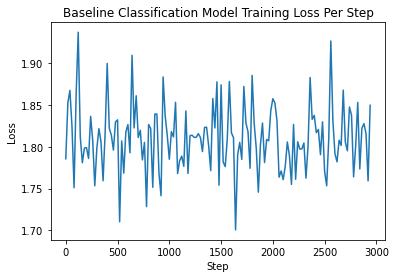

In [ ]:
y = loss
x = [i for i in range(0,2955, 20)]

plt.plot(x, y)

plt.title("Baseline Classification Model Training Loss Per Step")
plt.xlabel("Step")
plt.ylabel("Loss")

plt.show()

In [7]:
# experimental data, ignore this
import utils
from data_processing import get_data
from utils import save_model, load_model

## Data Hyperparameters
clean_genre=True
genres=["Metal", "Jazz", "Hip-Hop", "Pop", "Folk", "Country", "Rock", "Indie", "R&B", "Electronic"]

num_included=None
num_words_per_stanza = 150
training_ratio = 0.8

raw_data, train_dict, test_dict = get_data("../data.csv", 
                                 clean_genre = clean_genre,
                                 genres = genres,
                                 num_included = num_included,
                                 num_words_per_stanza = num_words_per_stanza,
                                 training_ratio = training_ratio)

import numpy as np

lyrics = train_dict["lyrics"] + test_dict["lyrics"]
labels = train_dict["labels"] + test_dict["labels"]

word_sets = {genre: set() for genre in genres}
for lyric, genre in zip(lyrics, labels):
  for word in lyric.split():
    word = word.strip("(),./\\|{}<>-_`~'\":;?!#@$%^&*").lower()
    word_sets[genre].add(word)

confusion_matrix = np.zeros((len(genres), len(genres)))
for i, reference_genre in enumerate(genres):
  for j, comparison_genre in enumerate(genres):
    reference_set = word_sets[reference_genre]
    comparison_set = word_sets[comparison_genre]

    overlap_set = reference_set.intersection(comparison_set)
    value = len(overlap_set) / len(reference_set)
    confusion_matrix[i][j] = value



Text(0.5, 42.0, 'Comparison Genre')

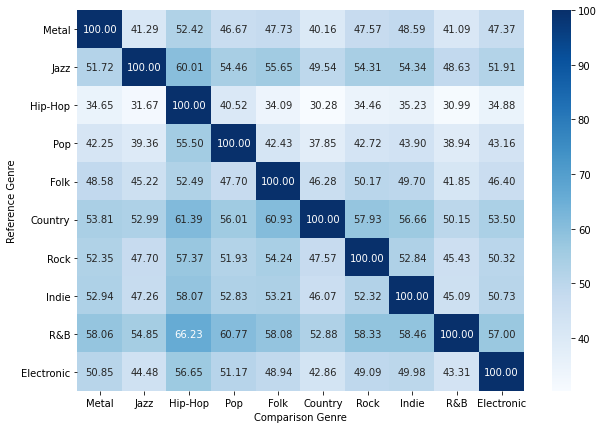

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

df_cm = pd.DataFrame(confusion_matrix * 100, 
                     index = genres,
                     columns = genres)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues')  
plt.ylabel("Reference Genre")
plt.xlabel("Comparison Genre")